<a href="https://colab.research.google.com/github/NeRaye/Kmeans-text-clustering/blob/main/Kmeans_text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importer les packages
import pandas as pd
import numpy as np
from collections import Counter
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from functools import reduce
import operator


> # **Partie 1 :** Analyse textuelle



1.   Télechargement du fichier texte contenant le jeu de données dans l'espace de travail



In [ ]:
#Uploader le fichier texte du dataset à partir de la machine
from google.colab import files
uploaded = files.upload()

Saving DBLP_Subset.txt to DBLP_Subset.txt


2.  Chargement du fichier du texte sous python

In [ ]:
#Ouverture du fichier
file_name = "DBLP_Subset.txt"
f = open(file_name,'r')

3.   Réalisation des traitements nécessaires sur le jeu de données

In [ ]:
#lecture du fichier et création d'une liste où chaque élément contient les informations d'un article
contents = f.read()
list_contents = contents.split('\n\n')
#supression des elements vides
list_contents = list(filter(None, list_contents))

In [ ]:
#Initialisation d'un dataframe vide qui va contenir toutes les informations du jeu de données
import pandas as pd
column_names = ["Id", "Title", "Authors", "Year", "PublicationVenue","ListCitations","Abstract", "NbrAuthors", "NbrCitations"] #colonnes du dataframe
df = pd.DataFrame(columns = column_names)

In [ ]:
#Remplir data frame avec les informations du jeu de données
#chaque ligne va contenir les données d'un article
i= -1
#On parcourt la liste des articles obtenu précédemment afin d'extraire la donnée à mettre dans chaque colonnes
for element in list_contents:
  i = i +1
  # pour chaque article on crée une liste
  list_element = element.split('#')
  list_element = list(filter(None, list_element))
  cit_list= list()
  for e in list_element:
    if(e.startswith('*')):
      e = e.replace('\n','')
      e = e[1:]
      df.loc[i,'Title'] = e 
    if(e.startswith('@')):
      a= e.replace('@','')
      list_authors = a.split('\n')
      list_authors = list(filter(None, list_authors))
      df.loc[i,'NbrAuthors'] = len(list_authors)
      str1 =""
      for m in list_authors:
        str1= str1+', '+ m
      str1 = str1[1:]
      df.loc[i,'Authors'] = str1
    if(e.startswith('t')):
      e = e.replace('t','')
      e = e.replace('\n','')
      df.loc[i,'Year'] = e
    if(e.startswith('c')):
      e = e.replace('\n','')
      e = e[1:]
      df.loc[i,'PublicationVenue'] = e 
    if(e.startswith('index')):
      df.loc[i,'Id'] = int(e.replace ('index',''))
    if(e.startswith('%')):
      e= e.replace('%','')
      e = e.replace('\n','')
      cit_list.append(int(e)) 
      df.loc[i,'ListCitations'] = cit_list
    if(e.startswith('!')):
      e = e.replace('\n','')
      df.loc[i,'Abstract'] = e.replace('!','')


In [ ]:
df

Id  ... NbrCitations
0       131751  ...          NaN
1       131752  ...          NaN
2       131756  ...          NaN
3       131759  ...          NaN
4       131760  ...          NaN
...        ...  ...          ...
37961  1600529  ...          NaN
37962  1600531  ...          NaN
37963  1600532  ...          NaN
37964  1600537  ...          NaN
37965  1600541  ...          NaN

[37963 rows x 9 columns]

In [ ]:
#Remplacer dans la colonne ListCitations NaN par empty list
df.loc[df['ListCitations'].isnull(),['ListCitations']] = df.loc[df['ListCitations'].isnull(),'ListCitations'].apply(lambda ListCitations: [])

In [ ]:
#Nettoyage : on enlève toutes lignes ou NbrAuthors = 0  et toutes les lignes où il y des NaN
#On a la df finale conforme à ce qui a été demandé
df['NbrCitations'] = df['NbrCitations'].fillna(0)
# Supprimer les lignes sans auteurs
indexNames = df[ df['NbrAuthors'] == 0 ].index
df.drop(indexNames , inplace=True)
df["Year"] = df["Year"].astype(int)
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df

Id  ... NbrCitations
0       131751  ...            0
1       131752  ...            0
2       131756  ...            0
3       131759  ...            0
4       131760  ...            0
...        ...  ...          ...
20547  1600529  ...            0
20548  1600531  ...            0
20549  1600532  ...            0
20550  1600537  ...            0
20551  1600541  ...            0

[20552 rows x 9 columns]

In [ ]:
#extraction des noms de revues avec moins de 50 articles
list_venue = list()
list_venue = df['PublicationVenue'].unique()
col_name = ["Venue", "NbrArticles"]

df_venue = pd.DataFrame(columns = col_name)
j = -1
for e in list_venue:
  if(df['PublicationVenue'].value_counts()[e] < 50):
    j = j +1
    df_venue.loc[j,'Venue']= e
    df_venue.loc[j,'NbrArticles'] = df['PublicationVenue'].value_counts()[e]
#df_venue contient toutes les revues avec moins de 50 
df_venue 

Venue NbrArticles
0                          Digital and Image Geometry          26
1                               Computing and Markets           6
2                 Complexity Theory: Current Research           1
3   Algorithms for Optimization with Incomplete In...           6
4                           Experimental Algorithmics          10
..                                                ...         ...
82                                             DBTest           7
83           Symposium on Solid and Physical Modeling          26
84                       Shape Modeling International          32
85             IEEE Symposium on Security and Privacy          33
86                                               SPAA          21

[87 rows x 2 columns]

In [ ]:
# Suppression des lignes contenant des articles publiés dans des revues avec moins de 50 articles
list_ref_deleted = list()
# iteration du df_revenu 
for index, row in df_venue.iterrows():
  indexNames = df[ df['PublicationVenue'] == row['Venue'] ].index
  list_ref_deleted.extend(indexNames)
  df_cleaned= df.drop(indexNames , inplace=True)


In [ ]:
#Compter le nombre de citations de chaque article en calculant les occurences de son Id dans la colonne ListCitations
nbr_cit_serie = pd.DataFrame(df.ListCitations.values.tolist()).stack().value_counts()
col_names = {"Id", "NbrCitations"}
#Construire une dataframe à partir de nbr_cit_serie
Nbr_cit_df = pd.DataFrame(columns = col_names)
Nbr_cit_df = nbr_cit_serie.to_frame().reset_index()
Nbr_cit_df = Nbr_cit_df.set_axis(['Id', 'NbrCitations'], axis=1, inplace=False)
Nbr_cit_df["Id"] = Nbr_cit_df["Id"].astype(int)
print(nbr_cit_serie)

759.0        401
1078390.0    216
2020.0       149
2595.0       134
2358.0       133
            ... 
94644.0        1
172078.0       1
133931.0       1
452689.0       1
145436.0       1
Length: 58686, dtype: int64


In [ ]:
#On remplit la colonne NbrCitations de df à partir de Nbr_cit_df
for index, row in Nbr_cit_df.iterrows():
  df.loc[df.Id == row['Id'], 'NbrCitations'] = row['NbrCitations']

In [ ]:
#CHECK THIS
df.reset_index(drop=True, inplace=True)
df

Id  ... NbrCitations
0       131751  ...            3
1       131752  ...            1
2       131756  ...            1
3       131759  ...            2
4       131760  ...            3
...        ...  ...          ...
19541  1600529  ...            0
19542  1600531  ...            0
19543  1600532  ...            0
19544  1600537  ...            0
19545  1600541  ...            0

[19546 rows x 9 columns]

In [ ]:
#Sauvegarde du dataframe dans un fichier CSV
df.to_csv('data_text.csv')

In [ ]:
#Exécuter ce code pour télécharger le dataframe après traitement sous format CSV
from google.colab import files
files.download('data_text.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
df=pd.read_csv("data_text.csv", sep=',')

4. Appliquer sur les abstracts les différent traitement : Supression des ponctuations, des stopwords, supression des chiffres et lemmatisation. 

In [ ]:
import nltk

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def clean_str(input_string:str, punctuation=string.punctuation, stop_words=stop_words) -> str:

  input_string = re.sub(r'https?://\S+|www\.\S+', '', input_string)
  input_string = re.sub(r'<.*?>', '', input_string)
  input_string = re.sub(r'[0-9]+', '', input_string)

  input_string = input_string.lower()
  

  for x in input_string: #ponctuation
    if x in punctuation:
      input_string = input_string.replace(x, ' ')

  input_string = ' '.join([word for word in input_string.split() if word not in stop_words]) #stop words

  input_string = re.sub(r'\s+', ' ', input_string).strip()
  
  lemmatizer= WordNetLemmatizer() #lemmatisation
  for x in input_string.split():
    input_string=input_string.replace(x, lemmatizer.lemmatize(x) )

  return input_string

In [ ]:
df['Abstract'] = df['Abstract'].apply(clean_str)
cleaned=list(df['Abstract']) #liste des abstracts nettoyés

5.1 Matrice documents-termes

In [ ]:
vectorizer = CountVectorizer()
bag = vectorizer.fit_transform(df['Abstract']) # générer la matrice sparse
print(bag.toarray())
bag_array = bag.toarray() #matrice docuements-termes 
bag_array.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(19546, 37585)

5.2 Matrice documents-entités

In [ ]:
!pip install spacy
! pip install spacy-transformers
! pip install spacy-entity-linker
! python -m spacy_entity_linker "download_knowledge_base"
! python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('entityLinker', last=True)

In [ ]:
def linked_entities_rep(article_texts): #fonction qui retourne l'ensemble des entités et la liste des entités pour chaque document 
  listEntity = []
  for a, abs in enumerate(article_texts):
    doc = nlp(str(abs))
    listInter = []
    all_linked_entities = doc._.linkedEntities
    for sent in doc.sents:
      for i in range(len(sent._.linkedEntities)):
        entity = sent._.linkedEntities[i].get_id()
        listInter.append(entity)

    listEntity.append(listInter)
    
  listEntityAll = reduce(operator.concat, listEntity)
  return listEntity, listEntityAll

In [ ]:
entityList, entityListAll = linked_entities_rep(cleaned)

In [ ]:
all_entities_unique = np.unique(entityListAll) #liste de toutes les entités
all_entities_unique

array([       1,        2,        3, ..., 74026205, 74397608, 74871156])

In [ ]:
linked_entities_sparse_matrix = np.zeros((len(cleaned), len(all_entities_unique) )) # initialisation à zéro 

for i in range(linked_entities_sparse_matrix.shape[0]): 
  for j in range (linked_entities_sparse_matrix.shape[1]):
    if all_entities_unique[j] in entityList[i]:
      linked_entities_sparse_matrix[i,j] =1

In [ ]:
print(linked_entities_sparse_matrix) #matrice documents-entités 
linked_entities_sparse_matrix.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(19546, 14354)

6. Matrice documents-auteurs

In [ ]:
#récupérer la liste des auteurs
liste_auteurs= ",".join(list(df['Authors']))
liste_auteurs= liste_auteurs.split(',')
liste_auteurs=np.unique(liste_auteurs)
print(len(liste_auteurs))
liste_auteurs

34653


array([' A. A. Makhnev', ' A. AbdelTawab', ' A. Antony Franklin', ...,
       'Étienne Duris', 'Éva Tardos', 'Ö. Ugur'], dtype='<U40')

In [ ]:
document_author_matrix=np.zeros((len(df['Id']), len(liste_auteurs))) #initialiser à zéro 
document_author_matrix.shape

In [ ]:
for i in range (len(df['Id'])): 
  for j in range (len(liste_auteurs)):
    if liste_auteurs[j] in df['Authors'][i].split(','):
      document_author_matrix[i,j] = 1 #matrice documents-auteurs 

> # **Partie 2 :** Analyse exploratoire des données

1.    Les auteurs les plus productifs

In [ ]:
#compte le nombre d'articles pour chaque auteur
list_cit = list()
for index, row in df.iterrows():
  aut = row['Authors']
  list_aut = list()
  list_aut = aut.split(',')
  list_cit.extend(list_aut)

list_author_citation = list()
for e in list_cit:
  if(e.startswith(' ')):
    e = e[1:]
  if(e.endswith(' ')):
    e = e[:-1]
  list_author_citation.append(e)
#compteur 
c_author = Counter(list_author_citation)
print(c_author)

Counter({'Alberto L. Sangiovanni-Vincentelli': 60, 'Robert K. Brayton': 59, 'David Blaauw': 57, 'Miodrag Potkonjak': 53, 'Jason Cong': 52, 'Lawrence T. Pileggi': 47, 'Sachin S. Sapatnekar': 43, 'David E. Goldberg': 43, 'Andrew B. Kahng': 40, 'Massoud Pedram': 40, 'Niraj K. Jha': 39, 'D. F. Wong': 38, 'Lei He': 37, 'Malgorzata Marek-Sadowska': 37, 'Yao-Wen Chang': 37, 'Kaushik Roy': 36, 'Dennis Sylvester': 36, 'Mahmut T. Kandemir': 33, 'Hai Zhou': 33, 'Surajit Chaudhuri': 33, 'Anand Raghunathan': 32, 'Jiawei Han': 32, 'Hector Garcia-Molina': 32, 'Kwang-Ting Cheng': 30, 'Peng Li': 30, 'Irith Pomeranz': 30, 'Michael Stonebraker': 30, 'Michael J. Carey': 30, 'Chung-Kuan Cheng': 29, 'Fabio Somenzi': 29, 'Byung Ro Moon': 29, 'David J. DeWitt': 29, 'Divesh Srivastava': 29, 'Rob A. Rutenbar': 28, 'Farid N. Najm': 28, 'Sudhakar M. Reddy': 28, 'Srinivas Devadas': 27, 'Kumara Sastry': 27, 'Raghu Ramakrishnan': 27, 'Jeffrey F. Naughton': 27, 'Joseph M. Hellerstein': 27, 'Martin D. F. Wong': 26, 'S

In [ ]:
#Construire un data frame à partir de la liste c_author, 
author_df = pd.DataFrame.from_dict(c_author, orient='index').reset_index()
author_df = author_df.rename(columns={'index':'Author', 0:'NbrArticles'})
# ordonner author_df  selon Nbr Articles dans l'ordre décroissant
author_df = author_df.sort_values(by=['NbrArticles'], ascending=False)
author_df

Author  NbrArticles
137    Alberto L. Sangiovanni-Vincentelli           60
997                     Robert K. Brayton           59
227                          David Blaauw           57
371                     Miodrag Potkonjak           53
102                            Jason Cong           52
...                                   ...          ...
12841                        Nell B. Dale            1
12840                      Alfred G. Dale            1
12839                         O. A. Daini            1
12837                    Marina Moscarini            1
31755               Ahmed Yassin Al-Dubai            1

[31756 rows x 2 columns]

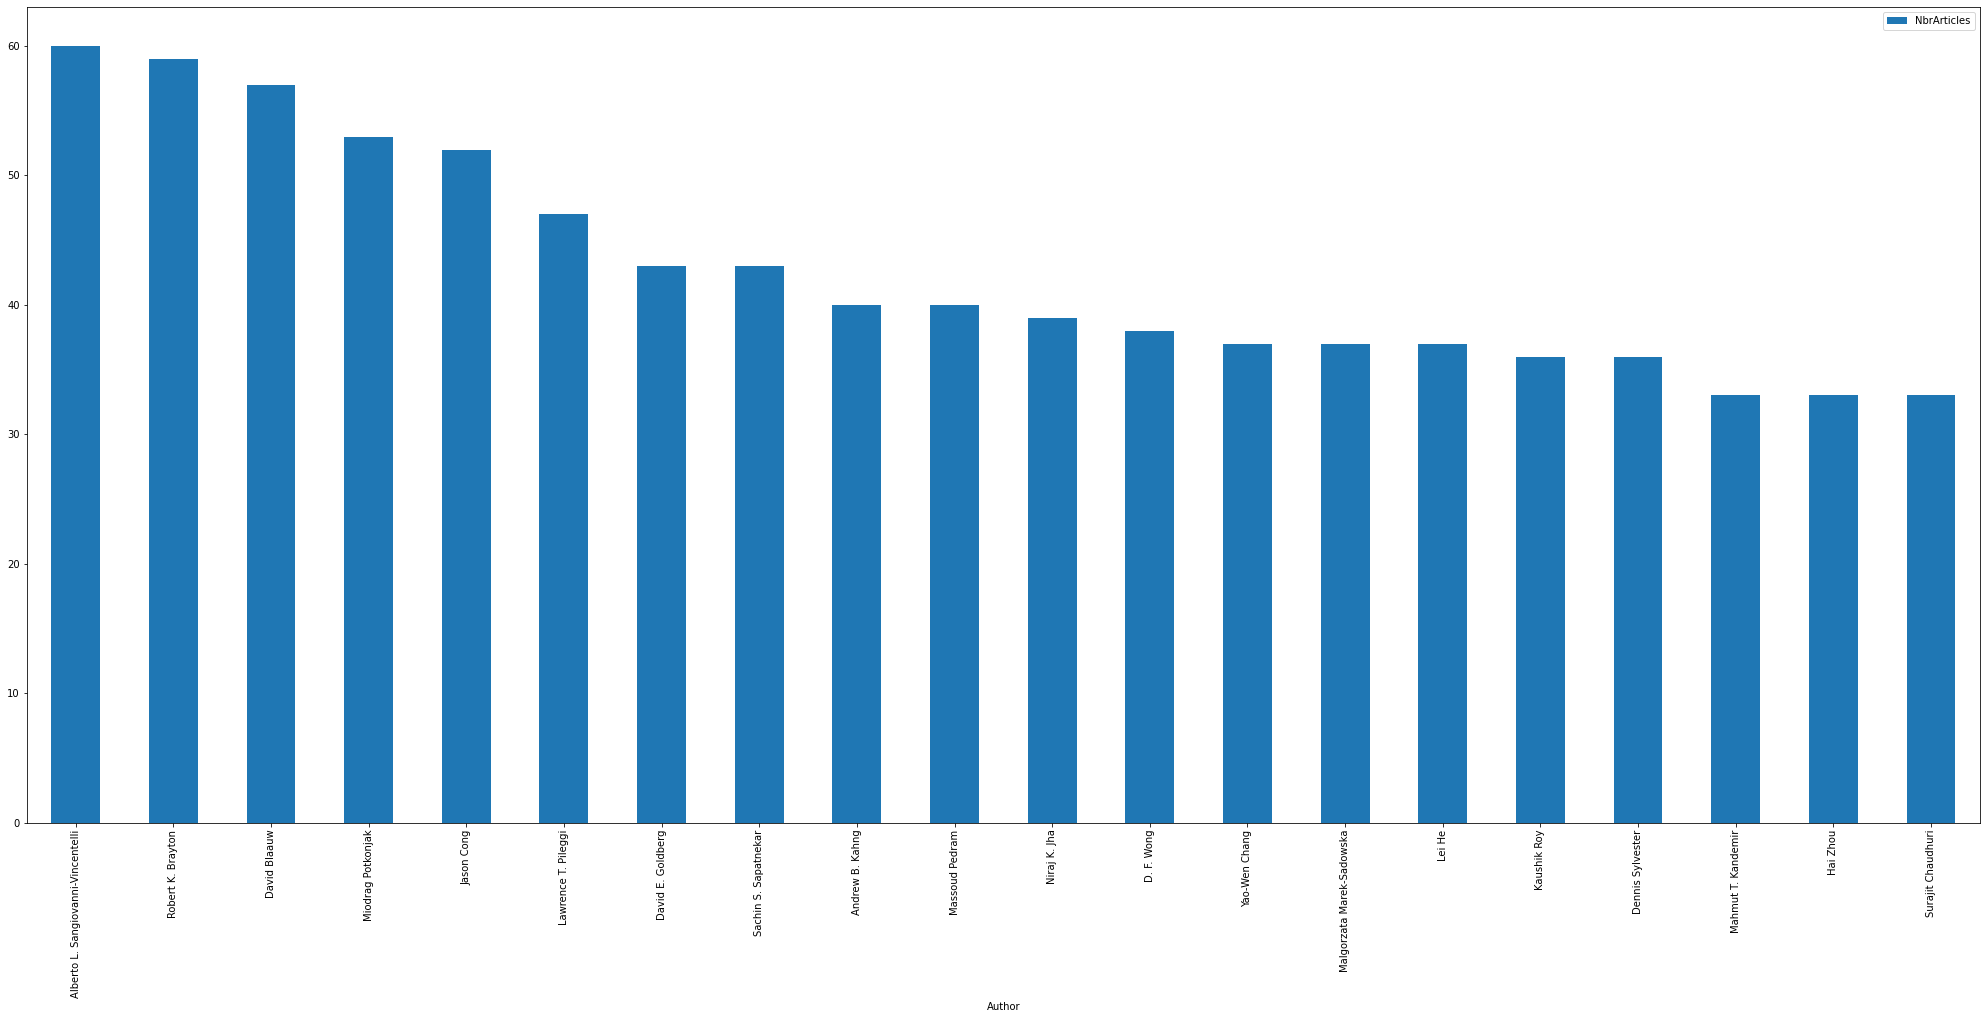

In [ ]:
#Prendre les 20 premières lignes du dataframe author_df i.e : les 20 auteurs les plus productifs
author_df_filtered = author_df.head(n=20)
#Création du diagramme en colonne à partir de author_df_filtered
ax = author_df_filtered.plot.bar(x='Author', y='NbrArticles', rot=90, figsize=(35, 15))


2.   Les articles les plus populaires selon les nombres de citations

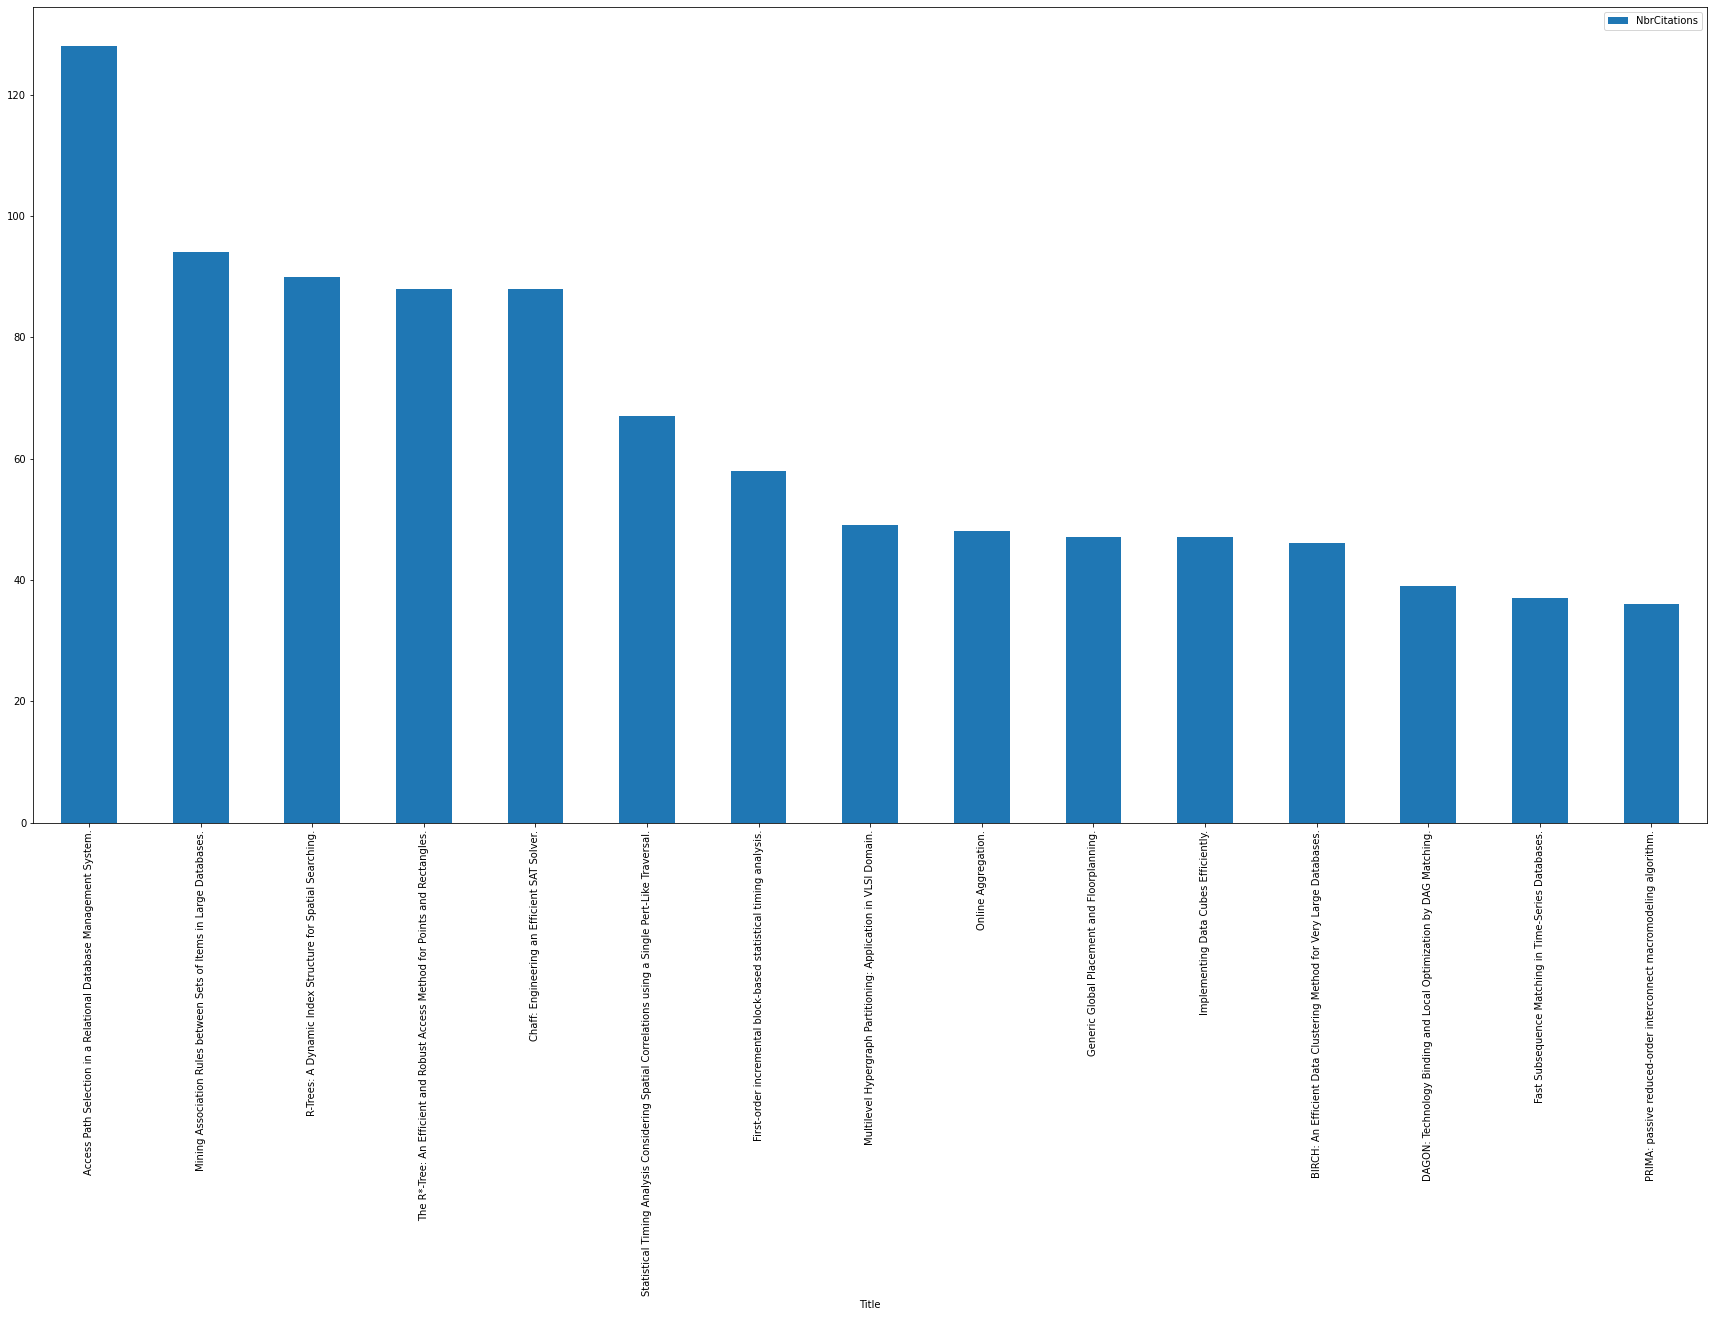

In [ ]:
#citation_df va contenir les lignes de df ordonné dans l'ordre décroissant selon NbrCitations
citation_df = df.sort_values(by=['NbrCitations'], ascending=False)
#On prend les 10 premières lignes
citation_df = citation_df.head(n=15)
#Création du diagramme
ax = citation_df.plot.bar(x='Title', y='NbrCitations', rot=90, figsize=(30, 15))


3.   Les années avec une grande productivité

In [ ]:
#Créer une liste qui va contenir toutes les valeurs de la colonne Year de df
list_year = list()
for index, row in df.iterrows():
  list_year.append(row['Year'])
#compter les occurences pour chaque valeur
c_year = Counter(list_year)
print(c_year)

Counter({2009: 3627, 2007: 2181, 2008: 1985, 2005: 1815, 2003: 1346, 2006: 1290, 2004: 890, 2002: 554, 2001: 526, 1999: 479, 1997: 429, 1995: 419, 2010: 404, 1989: 338, 2000: 314, 1998: 292, 1987: 266, 1985: 254, 1996: 243, 1993: 222, 1992: 196, 1994: 196, 1991: 176, 1990: 145, 1983: 141, 1988: 131, 1986: 120, 1981: 115, 1977: 92, 1975: 83, 1984: 50, 1982: 43, 1973: 41, 1971: 28, 1969: 28, 1980: 27, 1978: 25, 1979: 20, 1976: 12, 1972: 2, 1970: 1})


In [ ]:
#Construire un data frame à partir de c_year
year_df = pd.DataFrame.from_dict(c_year, orient='index').reset_index()
year_df = year_df.rename(columns={'index':'Year', 0:'NbrArticles'})
#ordonner selon NbrArticles dans l'ordre décroissant
year_df = year_df.sort_values(by=['NbrArticles'], ascending=False).reset_index()
year_df

index  Year  NbrArticles
0      37  2009         3627
1      21  2007         2181
2      22  2008         1985
3       3  2005         1815
4      12  2003         1346
5       1  2006         1290
6       7  2004          890
7       5  2002          554
8       6  2001          526
9      14  1999          479
10     16  1997          429
11     13  1995          419
12     40  2010          404
13      4  1989          338
14      8  2000          314
15     10  1998          292
16     11  1987          266
17     20  1985          254
18     15  1996          243
19     18  1993          222
20      2  1992          196
21     19  1994          196
22     23  1991          176
23      9  1990          145
24     26  1983          141
25      0  1988          131
26     17  1986          120
27     27  1981          115
28     25  1977           92
29     24  1975           83
30     32  1984           50
31     33  1982           43
32     28  1973           41
33     30  1969           28
34     29  1971           28
35     31  1980           27
36     36  1978           25
37     34  1979           20
38     35  1976           12
39     38  1972            2
40     39  1970            1

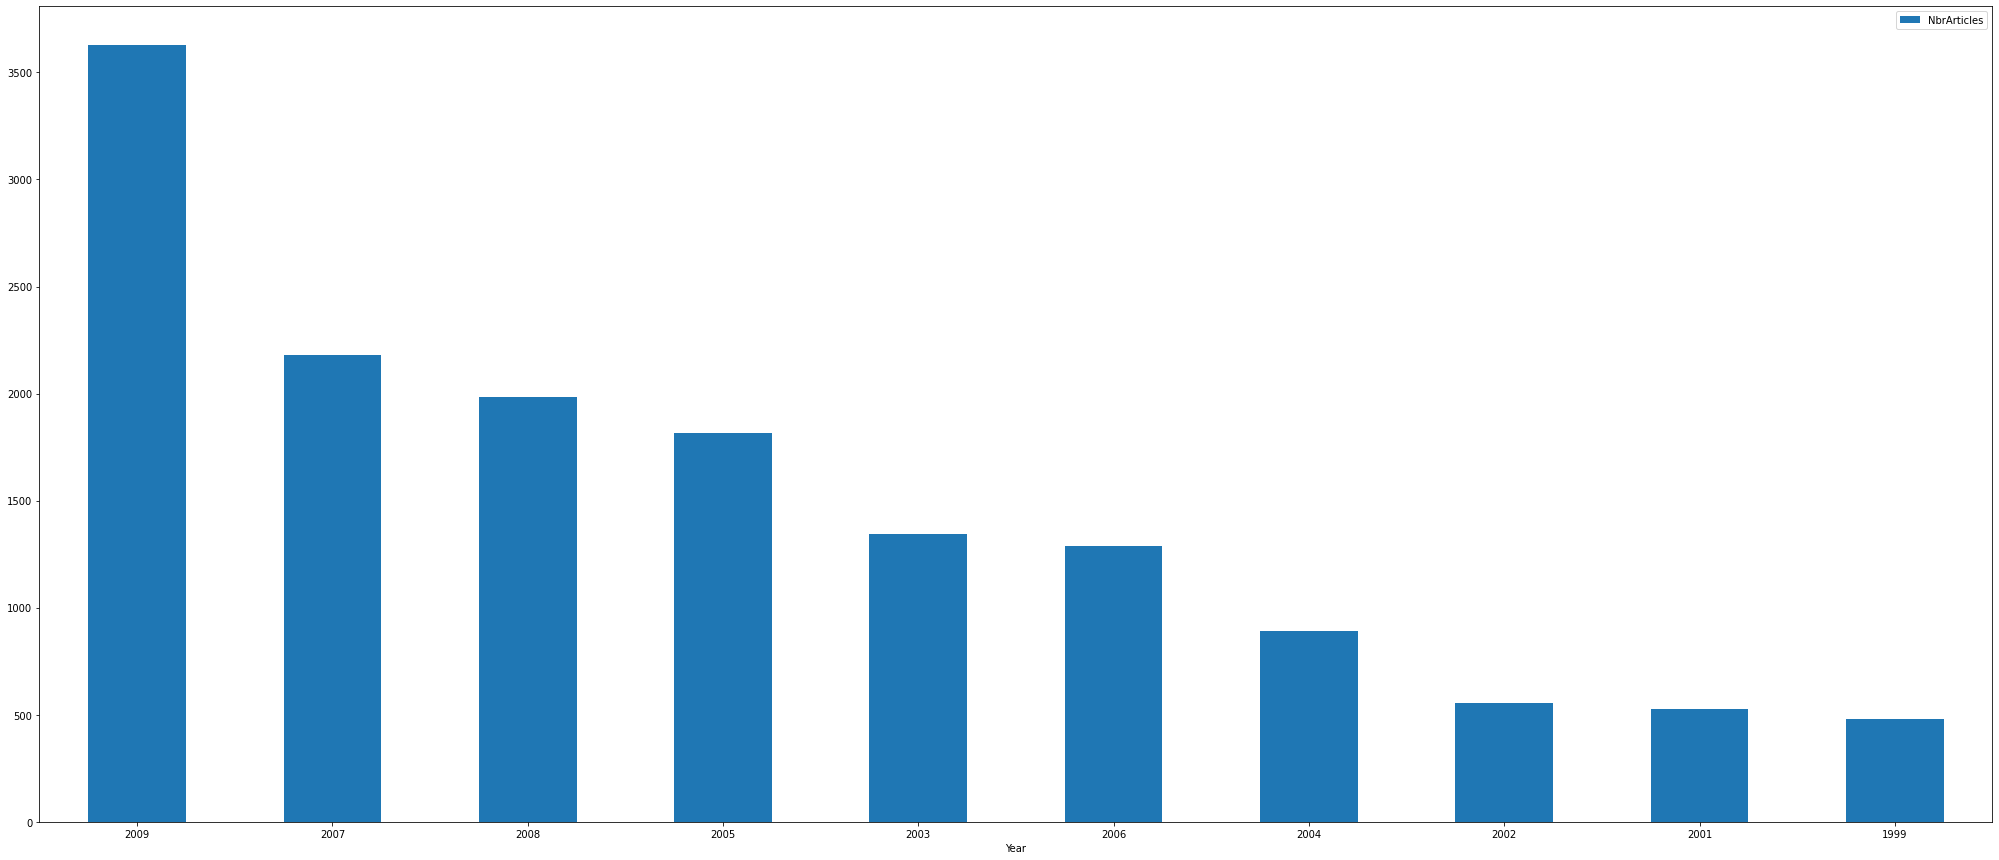

In [ ]:
#Création du diagramme avec les 10 premières ligne 
#i.e les 10 années les plus productives
year_df_filtered = year_df.head(n=10)
ax = year_df_filtered.plot.bar(x='Year', y='NbrArticles', rot = 0, figsize=(35, 15))

4.  Distribution du nombre d’articles par revue/conférence.

In [ ]:
#On groupe les lignes selon la colonne PublicationVenue et on calcule le nombre de ligne pour chaque revue 
#Ainsi on obtient le nombre d'articles par revue/conférence
groups_venue = df.groupby('PublicationVenue').size()
#Construire une data frame à partie de groups venue
venue_df = pd.DataFrame()
venue_df = groups_venue.to_frame().reset_index()
venue_df = venue_df.set_axis(['Venue', 'NbrArticles'], axis=1, inplace=False).reset_index()
#Ordonner dans l'ordre décroissant
venue_df = venue_df.sort_values(by=['NbrArticles'], ascending=False).reset_index()
venue_df

level_0  ...  NbrArticles
0         0  ...         2184
1        22  ...         2065
2         8  ...         1948
3        27  ...         1689
4        13  ...         1666
5         9  ...         1472
6         6  ...         1442
7        24  ...          936
8         4  ...          816
9        20  ...          812
10       12  ...          587
11       28  ...          510
12       29  ...          445
13        2  ...          324
14        5  ...          307
15       10  ...          269
16        3  ...          242
17        7  ...          234
18       16  ...          152
19       17  ...          145
20       18  ...          144
21       30  ...          138
22       26  ...          130
23       21  ...          114
24        1  ...          113
25       33  ...           92
26       23  ...           85
27       25  ...           83
28       19  ...           76
29       31  ...           75
30       14  ...           71
31       11  ...           66
32       32  ...           59
33       15  ...           55

[34 rows x 4 columns]

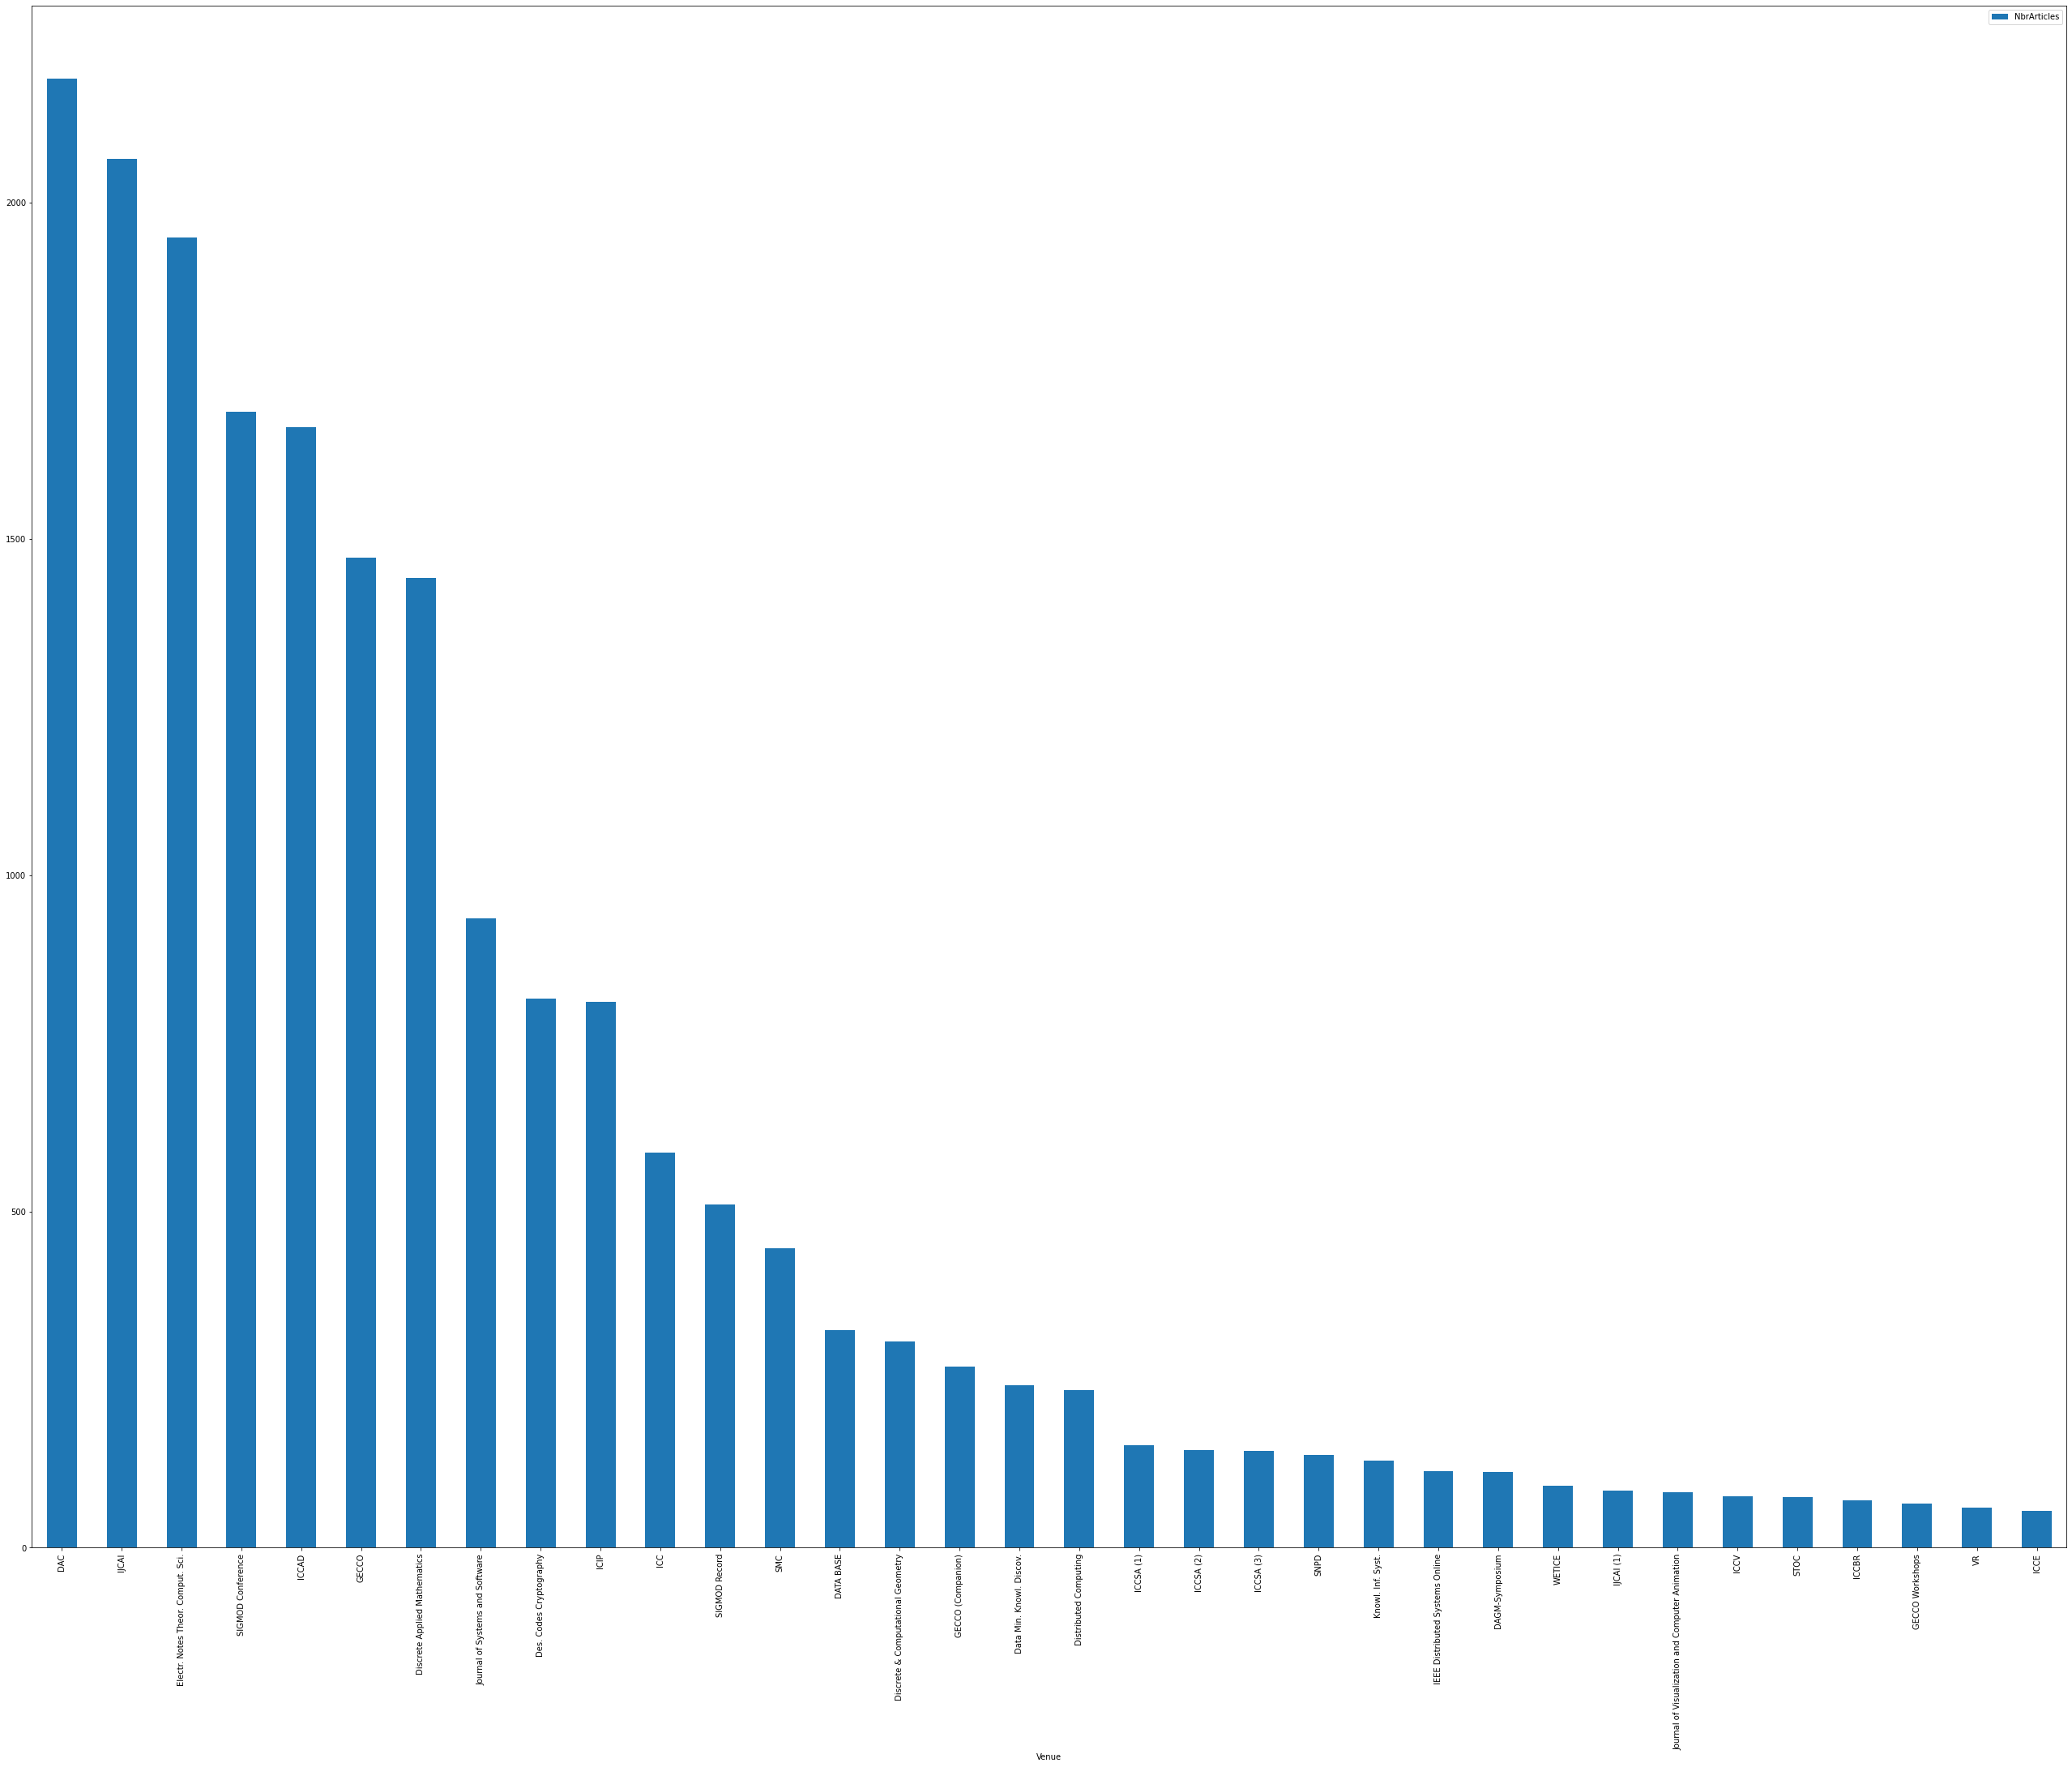

In [ ]:
#Création du diagramme
ax = venue_df.plot.bar(x='Venue', y='NbrArticles', rot = 90, figsize=(45, 35))

5.  Distribution du nombre de citations par revue

In [ ]:
#On somme les valeurs de la colonne NbrCitations selon les groupes construit à partir de PublicationVenue
cit_venue = df.groupby(['PublicationVenue'])['NbrCitations'].sum()
#Construire le data frame à partir de cit_venue
cit_venue_df = pd.DataFrame()
cit_venue_df = cit_venue.to_frame().reset_index()
cit_venue_df = cit_venue_df.set_axis(['Venue', 'NbrCitations'], axis=1, inplace=False)
#Ordonner dans l'ordre décroissant selon la colonne NbrCitations
cit_venue_df = cit_venue_df.sort_values(by=['NbrCitations'], ascending=False).reset_index()
cit_venue_df


index                                            Venue  NbrCitations
0      27                                SIGMOD Conference          5016
1       0                                              DAC          4089
2      13                                            ICCAD          3271
3       9                                            GECCO           880
4      28                                    SIGMOD Record           485
5       6                     Discrete Applied Mathematics           421
6       4                          Des. Codes Cryptography           380
7      22                                            IJCAI           377
8      24                  Journal of Systems and Software           286
9       8                Electr. Notes Theor. Comput. Sci.           276
10      3                         Data Min. Knowl. Discov.           175
11      7                            Distributed Computing           151
12      2                                        DATA BASE            99
13     10                                GECCO (Companion)            64
14     19                                             ICCV            57
15     11                                  GECCO Workshops            29
16     26                                Knowl. Inf. Syst.            20
17     23                                        IJCAI (1)            13
18      5                Discrete & Computational Geometry            11
19     31                                             STOC             7
20     25  Journal of Visualization and Computer Animation             3
21     17                                        ICCSA (2)             2
22     21                  IEEE Distributed Systems Online             1
23      1                                   DAGM-Symposium             1
24     12                                              ICC             1
25     20                                             ICIP             0
26     18                                        ICCSA (3)             0
27     16                                        ICCSA (1)             0
28     15                                             ICCE             0
29     14                                            ICCBR             0
30     29                                              SMC             0
31     30                                             SNPD             0
32     32                                               VR             0
33     33                                           WETICE             0

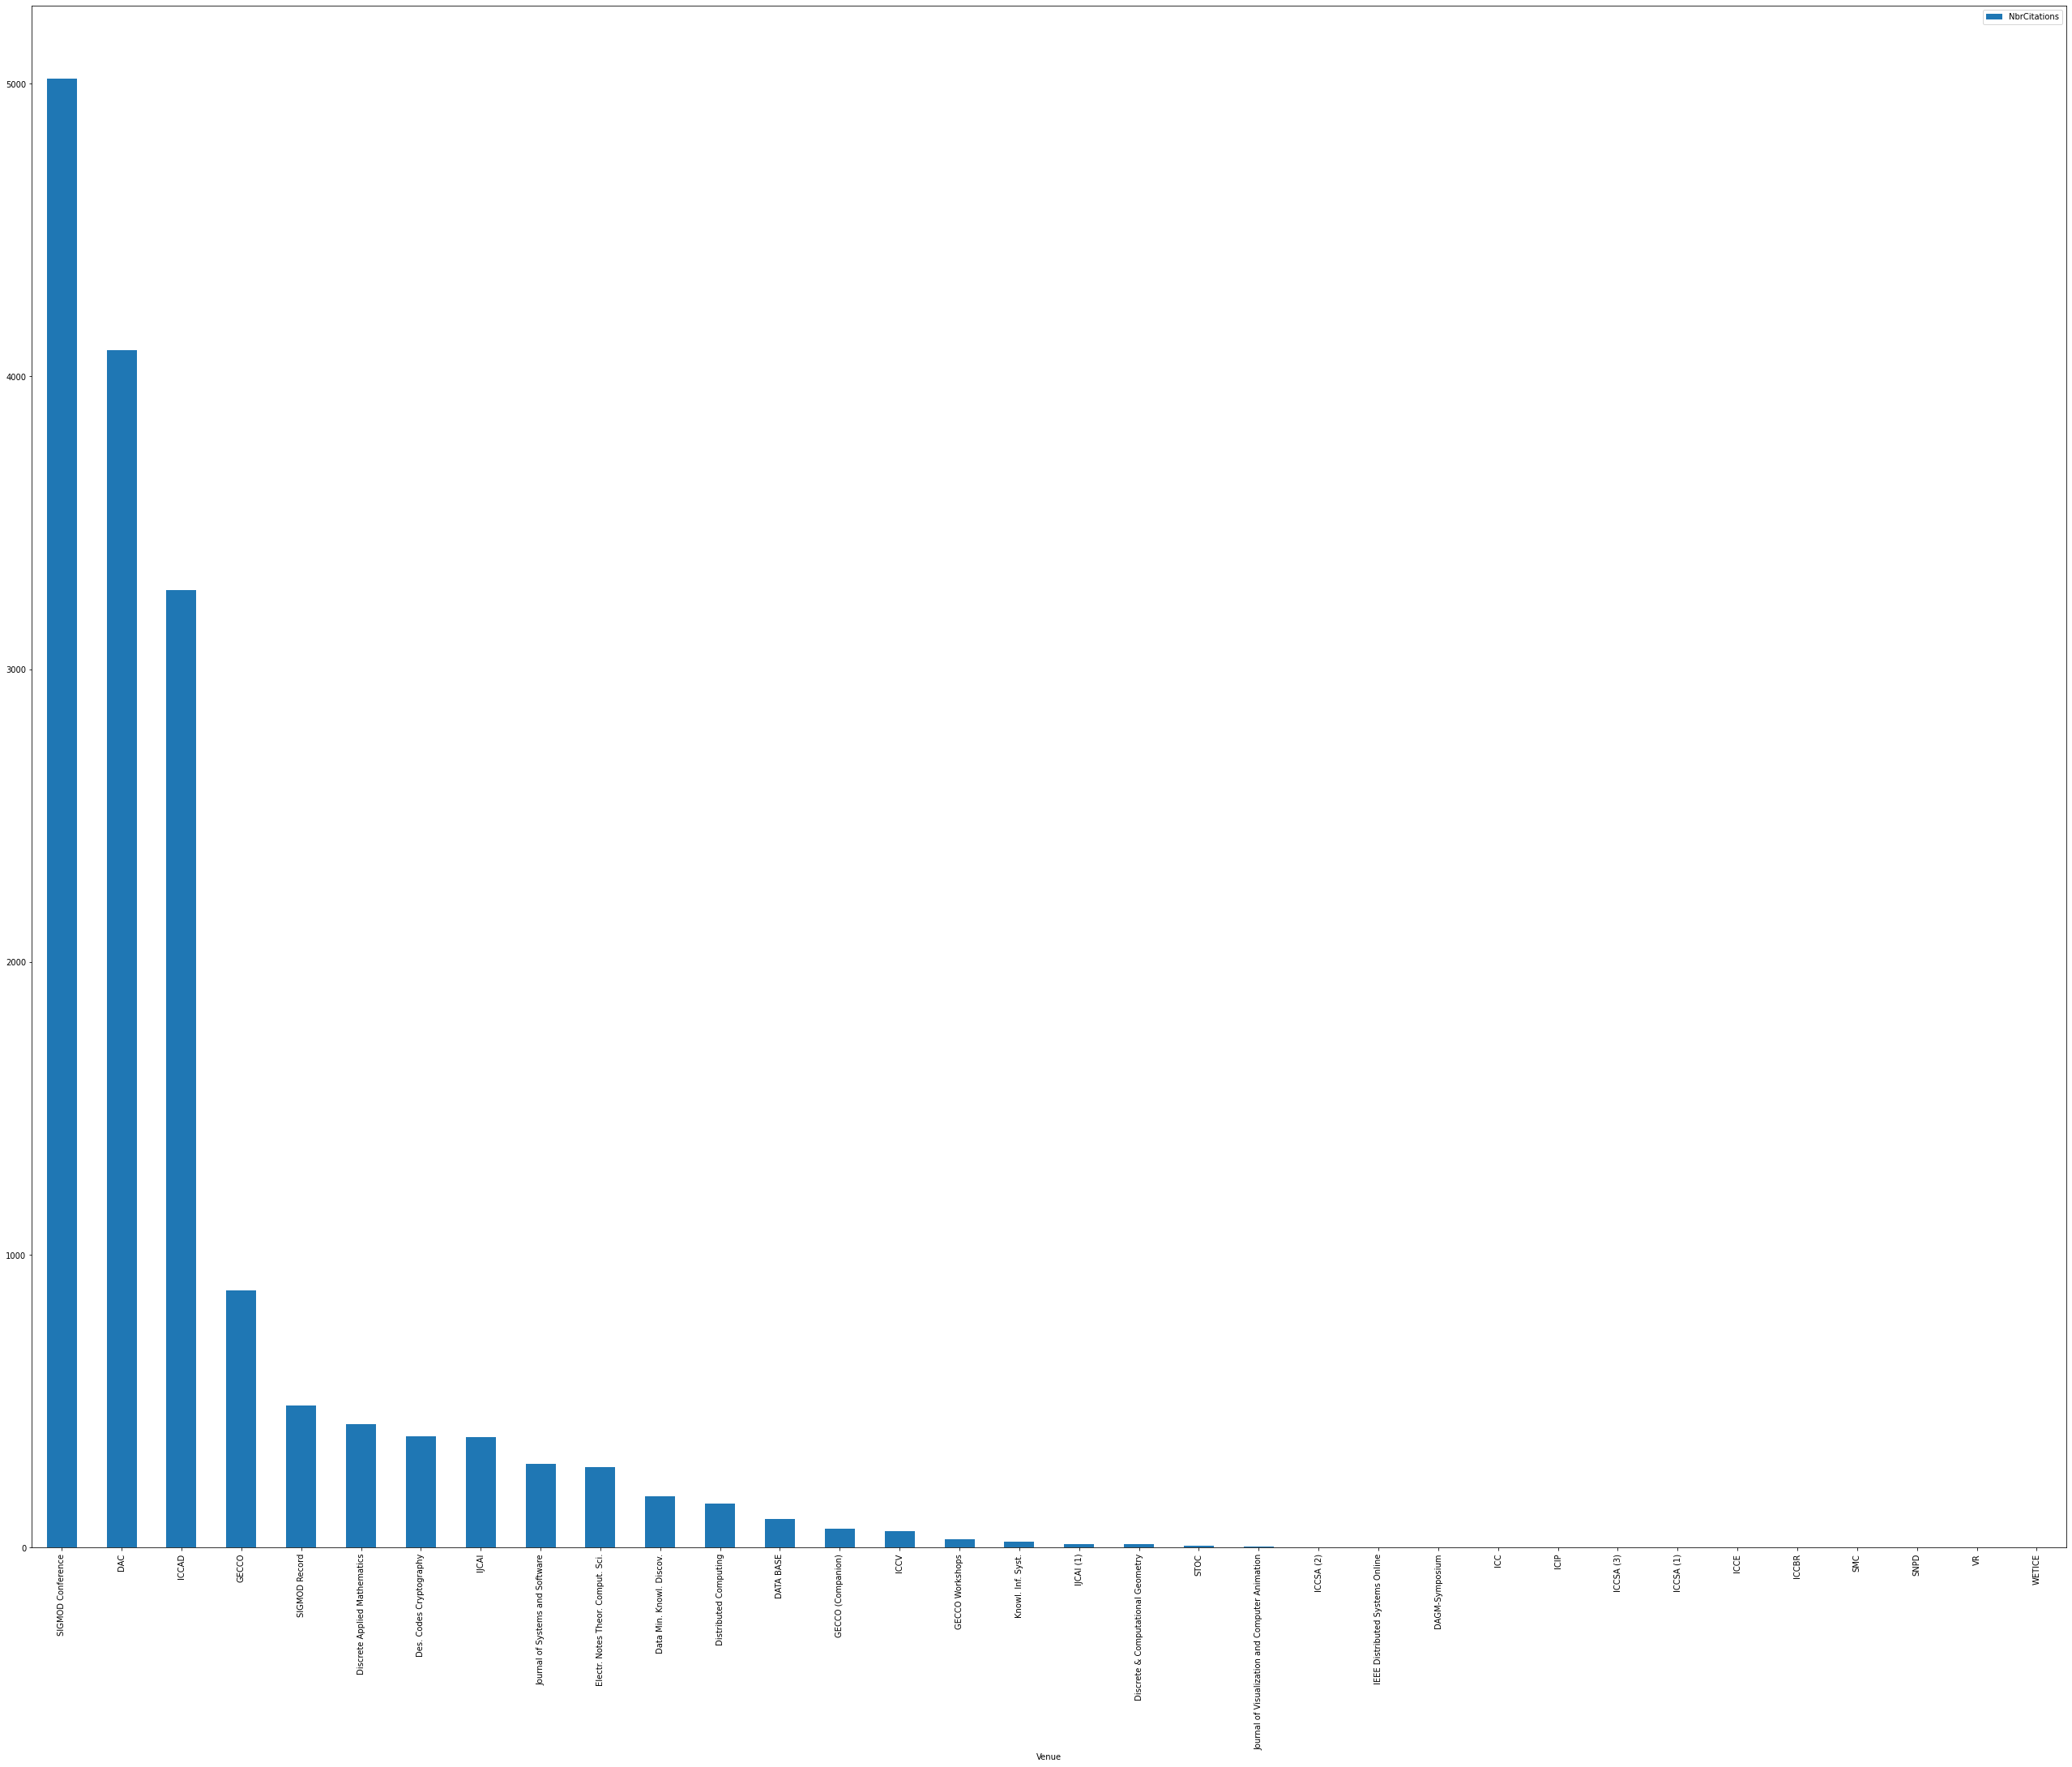

In [ ]:
#Céer le diagramme
ax = cit_venue_df.plot.bar(x='Venue', y='NbrCitations', rot = 90, figsize=(45, 35))

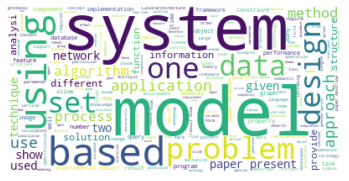

In [ ]:
#nuage de mots des abstracts nettoyés
from wordcloud import WordCloud
texts = " ".join(cleaned)
wordcloud = WordCloud(background_color="white").generate(texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Partie 3**:  Classification non supevisé

Dans cette partie, étant donnée la quantité volumineuse de données et  la complexité des traitements nous avons rencontrés des difficultés  avec google colab car les ressources sont limités, de ce fait l'exécution de chaque partie du code a nécessité à plusieurs reprises le redémarrage de l'environnement d'exécution afin de libérer la RAM.



On applique une ACP sur nos données dans le but de visualiser les classes: le résultat de l'ACP nous montre qu'il n'existe pas de séparation évidente entre nos classes, car tous les points sont proches.  

In [ ]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pca.fit(bag_array)
bag_array_pca= pca.transform(bag_array)

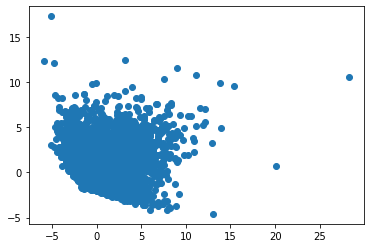

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.scatter(bag_array_pca[:,0], bag_array_pca[:,1])
plt.show()

Dans le but de calculer la précision par la suite avec coclust, on procéde ici à un encodage ordinal de la variable PublicationVenue, qui est une variable catégorielle 

In [ ]:
df1=df.copy()

from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df1['PublicationVenue'] = ord_enc.fit_transform(df1[['PublicationVenue']]) #PublicationVenue va contenir des valeurs numériques représantant les classes

np.unique(df1['PublicationVenue']).shape 

(34,)

Kmeans sur la matrice documents-termes

In [ ]:
from sklearn.cluster import KMeans

kmeanModel_bow = KMeans(n_clusters=34)
kmeanModel_bow.fit(bag_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=34, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
!pip install coclust

In [ ]:
import coclust.evaluation.external
coclust.evaluation.external.accuracy(df1['PublicationVenue'],kmeanModel_bow.labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.189501688324977

In [ ]:
#Regrouper les abstracts de chaque cluster 
df['PublicationVenue_Predicted']= kmeanModel_bow.labels_
Abstracts_per_class=[]
for i in np.unique(df['PublicationVenue_Predicted']):
  Abstracts_per_class.append(list(df.loc[df['PublicationVenue_Predicted'] == i]['Abstract']))


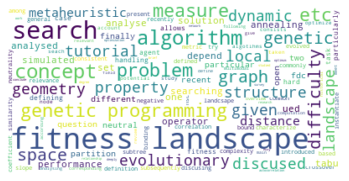

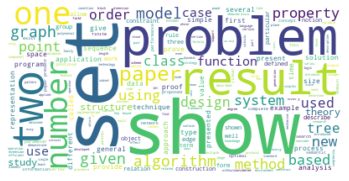

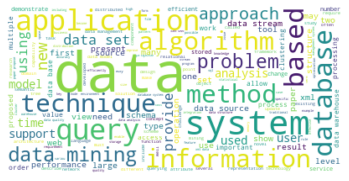

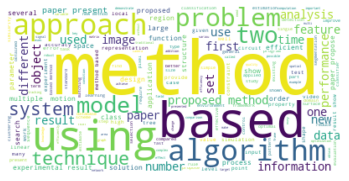

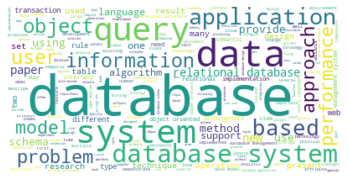

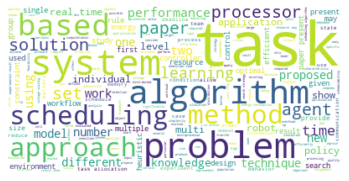

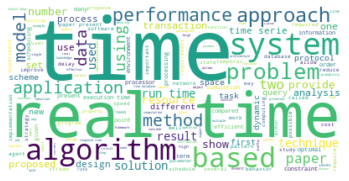

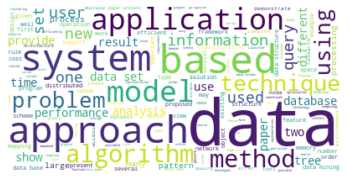

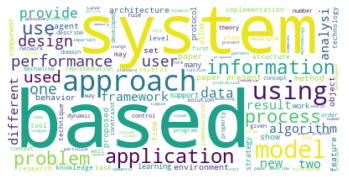

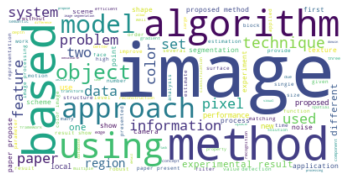

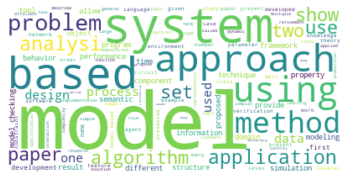

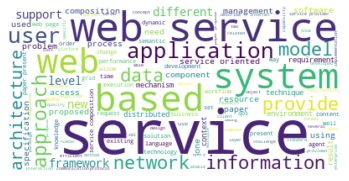

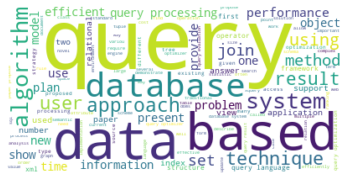

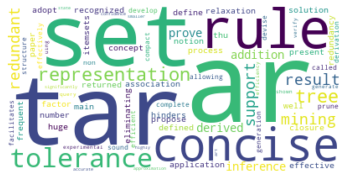

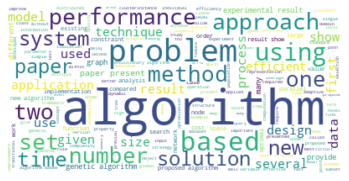

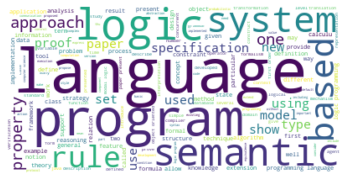

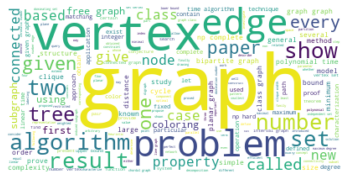

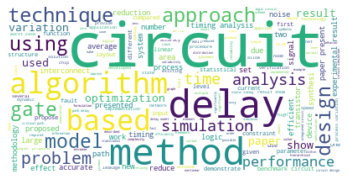

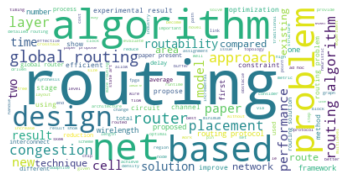

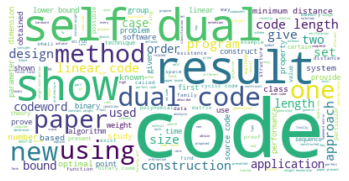

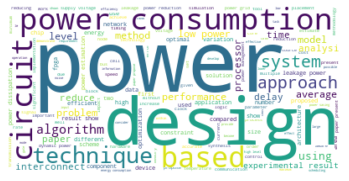

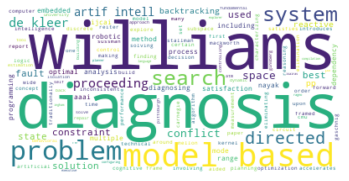

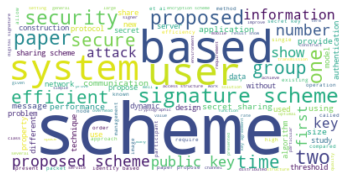

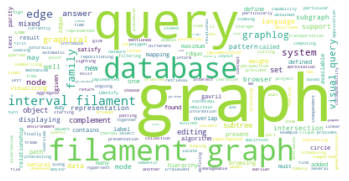

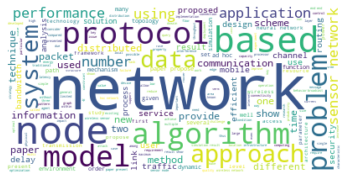

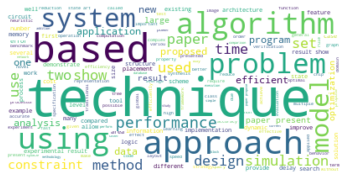

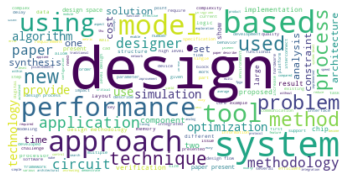

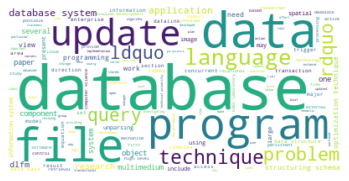

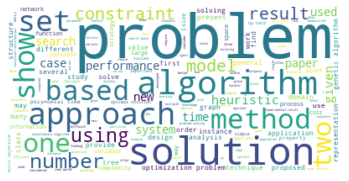

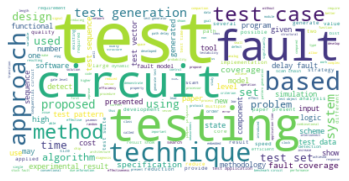

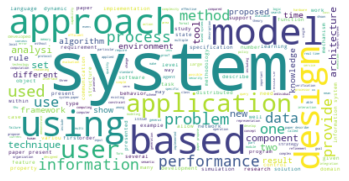

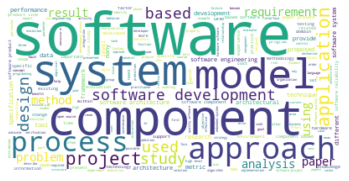

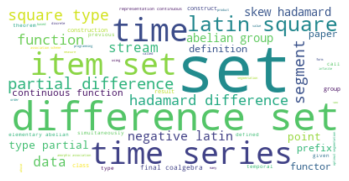

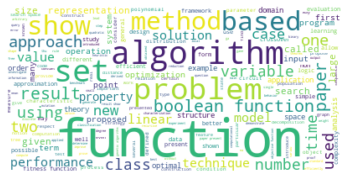

In [ ]:
#Affciher le nuage de point pour chaque cluster 
for i in Abstracts_per_class:
  texts = " ".join(i)
  wordcloud = WordCloud(background_color="white").generate(texts)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()




Kmeans avec la matrice documents-entités

In [ ]:
from sklearn.cluster import KMeans
kmeanModel_entite = KMeans(n_clusters=34)
kmeanModel_entite.fit(linked_entities_sparse_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=34, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
import coclust.evaluation.external

coclust.evaluation.external.accuracy(df1['PublicationVenue'],kmeanModel_entite.labels_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.14038677990381665

Kmeans sphérique avec la matrice documents-termes

In [ ]:
import coclust.clustering

spheKmeanModel_bow=SphericalKmeans(n_clusters=34)
spheKmeanModel_bow.fit(bag_array)


In [ ]:
coclust.evaluation.external.accuracy(df1['PublicationVenue'],spheKmeanModel_bow.labels_)

Kmeans sphérique avec la matrice documents-entités 

In [ ]:
spheKmeanModel_entite=SphericalKmeans(n_clusters=34)
spheKmeanModel_entite.fit(linked_entities_sparse_matrix)

In [ ]:
coclust.evaluation.external.accuracy(df1['PublicationVenue'],spheKmeanModel_entite.labels_)

On peut utiliser la méthode Elbow pour déterminer un nombre de cluster optimal (non exploité à cause de la limitation des ressources)

In [ ]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,10) #tester un nombre de clusters allant de 1 jusqu'a 10 
for i in K:
    kmeanModel_elbow = KMeans(n_clusters=i)
    kmeanModel.fit(bag_array)
    distortions.append(kmeanModel.inertia_)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Méthode Elbow')
plt.show()